# 5-4,TensorBoard可视化

在我们的炼丹过程中，如果能够使用丰富的图像来展示模型的结构，指标的变化，参数的分布，输入的形态等信息，无疑会提升我们对问题的洞察力，并增加许多炼丹的乐趣。

TensorBoard正是这样一个神奇的炼丹可视化辅助工具。它原是TensorFlow的小弟，但它也能够很好地和Pytorch进行配合。甚至在Pytorch中使用TensorBoard比TensorFlow中使用TensorBoard还要来的更加简单和自然。

本篇结构：

一，可视化模型结构

二，可视化指标变化

三，可视化参数分布

四，可视化原始图像

五，可视化人工绘图

六，torchkeras中的TensorBoard回调函数



## 〇，Tensorboard可视化概述

Pytorch中利用TensorBoard可视化的大概过程如下：

首先在Pytorch中指定一个目录创建一个torch.utils.tensorboard.SummaryWriter日志写入器。

然后根据需要可视化的信息，利用日志写入器将相应信息日志写入我们指定的目录。

最后就可以传入日志目录作为参数启动TensorBoard，然后就可以在TensorBoard中愉快地看片了。

我们主要介绍Pytorch中利用TensorBoard进行如下方面信息的可视化的方法。

* 可视化模型结构： writer.add_graph

* 可视化指标变化： writer.add_scalar

* 可视化参数分布： writer.add_histogram

* 可视化原始图像： writer.add_image 或 writer.add_images

* 可视化人工绘图： writer.add_figure


这些方法尽管非常简单，但每次训练的时候都要调取调试还是非常麻烦的。

作者在torchkeras库中集成了一个torchkeras.callback.TensorBoard回调函数工具，

利用该工具配合torchkeras.LightModel可以用极少的代码在TensorBoard中实现绝大部分常用的可视化功能。


包括：

* 可视化模型结构

* 可视化指标变化

* 可视化参数分布

* 可视化超参调整

可以说非常方便哦。😋😋 



In [ ]:
!pip install tensorboard 

In [8]:
import torch 
import torchkeras
import tensorboard 

print("torch.__version__="+torch.__version__) 
print("torchkeras.__version__="+torchkeras.__version__) 
print("tensorboard.__version__="+tensorboard.__version__) 

torch.__version__=2.4.0
torchkeras.__version__=4.0.0
tensorboard.__version__=2.17.1


## 一，可视化模型结构

In [9]:
import torch 
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import torchkeras 


In [10]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        y = self.linear2(x)
        return y
        
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
)


In [11]:
from torchkeras import summary 
summary(net,input_shape= (3,32,32));


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                            [-1, 32, 30, 30]                  896
MaxPool2d-2                         [-1, 32, 15, 15]                    0
Conv2d-3                            [-1, 64, 11, 11]               51,264
MaxPool2d-4                           [-1, 64, 5, 5]                    0
Dropout2d-5                           [-1, 64, 5, 5]                    0
AdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0
Flatten-7                                   [-1, 64]                    0
Linear-8                                    [-1, 32]                2,080
ReLU-9                                      [-1, 32]                    0
Linear-10                                    [-1, 1]                   33
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
-----------------------------------------

In [12]:
writer = SummaryWriter('./data/tensorboard')
writer.add_graph(net,input_to_model = torch.rand(1,3,32,32))
writer.close()


In [13]:
%load_ext tensorboard
#%tensorboard --logdir ./data/tensorboard

In [14]:
from tensorboard import notebook
#查看启动的tensorboard程序
notebook.list() 

No known TensorBoard instances running.


In [ ]:
#启动tensorboard程序
notebook.start("--logdir ./data/tensorboard")
#等价于在命令行中执行 tensorboard --logdir ./data/tensorboard
#可以在浏览器中打开 http://localhost:6006/ 查看

## 二，可视化指标变化

有时候在训练过程中，如果能够实时动态地查看loss和各种metric的变化曲线，那么无疑可以帮助我们更加直观地了解模型的训练情况。

注意，writer.add_scalar仅能对标量的值的变化进行可视化。因此它一般用于对loss和metric的变化进行可视化分析。


In [16]:
import numpy as np 
import torch 
from torch.utils.tensorboard import SummaryWriter


# f(x) = a*x**2 + b*x + c的最小值
x = torch.tensor(0.0,requires_grad = True) # x需要被求导
a = torch.tensor(1.0)
b = torch.tensor(-2.0)
c = torch.tensor(1.0)

optimizer = torch.optim.SGD(params=[x],lr = 0.01)


def f(x):
    result = a*torch.pow(x,2) + b*x + c 
    return(result)

writer = SummaryWriter('./data/tensorboard')
for i in range(500):
    optimizer.zero_grad()
    y = f(x)
    y.backward()
    optimizer.step()
    writer.add_scalar("x",x.item(),i) #日志中记录x在第step i 的值
    writer.add_scalar("y",y.item(),i) #日志中记录y在第step i 的值

writer.close()
    
print("y=",f(x).data,";","x=",x.data)


y= tensor(0.) ; x= tensor(1.0000)


## 三，可视化参数分布

如果需要对模型的参数(一般非标量)在训练过程中的变化进行可视化，可以使用 writer.add_histogram。

它能够观测张量值分布的直方图随训练步骤的变化趋势。

In [17]:
import numpy as np 
import torch 
from torch.utils.tensorboard import SummaryWriter


# 创建正态分布的张量模拟参数矩阵
def norm(mean,std):
    t = std*torch.randn((100,20))+mean
    return t

writer = SummaryWriter('./data/tensorboard')
for step,mean in enumerate(range(-10,10,1)):
    w = norm(mean,1)
    writer.add_histogram("w",w, step)
    writer.flush()
writer.close()


## 四，可视化原始图像

如果我们做图像相关的任务，也可以将原始的图片在tensorboard中进行可视化展示。

如果只写入一张图片信息，可以使用writer.add_image。

如果要写入多张图片信息，可以使用writer.add_images。

也可以用 torchvision.utils.make_grid将多张图片拼成一张图片，然后用writer.add_image写入。

注意，传入的是代表图片信息的Pytorch中的张量数据。


In [18]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as T,datasets 


transform_img = T.Compose(
    [T.ToTensor()])

def transform_label(x):
    return torch.tensor([x]).float()


In [19]:
ds_train = datasets.ImageFolder("./eat_pytorch_datasets/cifar2/train/",
            transform = transform_img,target_transform= transform_label)
ds_val = datasets.ImageFolder("./eat_pytorch_datasets/cifar2/test/",
            transform = transform_img,target_transform= transform_label)

print(ds_train.class_to_idx)

dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True)
dl_val = DataLoader(ds_val,batch_size = 50,shuffle = True)

images,labels = next(iter(dl_train))

# 仅查看一张图片
writer = SummaryWriter('./data/tensorboard')
writer.add_image('images[0]', images[0])
writer.close()

# 将多张图片拼接成一张图片，中间用黑色网格分割
writer = SummaryWriter('./data/tensorboard')
# create grid of images
img_grid = torchvision.utils.make_grid(images)
writer.add_image('image_grid', img_grid)
writer.close()

# 将多张图片直接写入
writer = SummaryWriter('./data/tensorboard')
writer.add_images("images",images,global_step = 0)
writer.close()


{'0_airplane': 0, '1_automobile': 1}


## 五，可视化人工绘图

如果我们将matplotlib绘图的结果再 tensorboard中展示，可以使用 add_figure.

注意，和writer.add_image不同的是，writer.add_figure需要传入matplotlib的figure对象。


In [20]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as T,datasets 

transform_img = T.Compose(
    [T.ToTensor()])

def transform_label(x):
    return torch.tensor([x]).float()


ds_train = datasets.ImageFolder("./eat_pytorch_datasets/cifar2/train/",
            transform = transform_img,target_transform= transform_label)
ds_val = datasets.ImageFolder("./eat_pytorch_datasets/cifar2/test/",
            transform = transform_img,target_transform= transform_label)

print(ds_train.class_to_idx)

dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True)
dl_val = DataLoader(ds_val,batch_size = 50,shuffle = True)

images,labels = next(iter(dl_train))

{'0_airplane': 0, '1_automobile': 1}


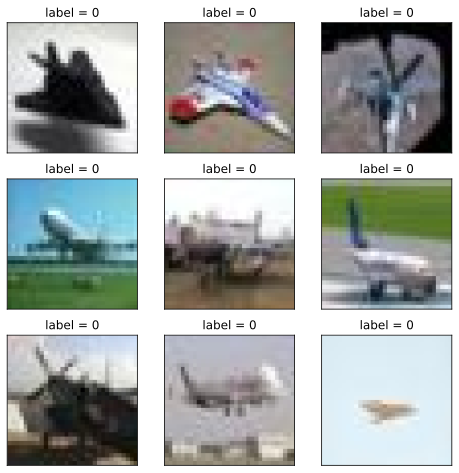

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt 

figure = plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [22]:
writer = SummaryWriter('./data/tensorboard')
writer.add_figure('figure',figure,global_step=0)
writer.close()                         

## 六，torchkeras中的TensorBoard回调函数

下面是一个在torchkeras中调用TensorBoard回调函数实现
常用可视化功能的完整范例。

非常简单。


In [23]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

import torchkeras #Attention this line 


### 1，准备数据

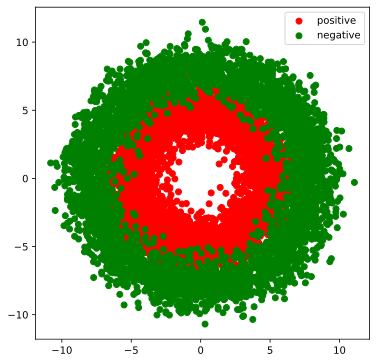

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#number of samples
n_positive,n_negative = 4000,4000

#positive samples
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#negative samples
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#concat positive and negative samples
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#visual samples
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0],Xp[:,1],c = "r")
plt.scatter(Xn[:,0],Xn[:,1],c = "g")
plt.legend(["positive","negative"]);


In [25]:
ds = TensorDataset(X,Y)
ds_train,ds_val = torch.utils.data.random_split(ds,[int(len(ds)*0.7),len(ds)-int(len(ds)*0.7)])
dl_train = DataLoader(ds_train,batch_size = 16,shuffle=True)
dl_val = DataLoader(ds_val,batch_size = 16)

for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)


torch.Size([16, 2])
torch.Size([16, 1])


### 2，定义模型

In [29]:
class Net(nn.Module):  
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,16)
        self.fc2 = nn.Linear(16,8) 
        self.fc3 = nn.Linear(8,1)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.fc3(x) #don't need nn.Sigmoid()
        return y
         


In [30]:
from torchkeras.metrics import Accuracy 
from torchkeras import KerasModel
net = Net() 
loss_fn = nn.BCEWithLogitsLoss()
metric_dict = {"acc":Accuracy()}

lr = 0.0001
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

model = KerasModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metric_dict,
                   optimizer = optimizer
                  )       

from torchkeras import summary
summary(model,input_data=features);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                    [-1, 16]                   48
Linear-2                                     [-1, 8]                  136
Linear-3                                     [-1, 1]                    9
Total params: 193
Trainable params: 193
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000076
Forward/backward pass size (MB): 0.000191
Params size (MB): 0.000736
Estimated Total Size (MB): 0.001003
--------------------------------------------------------------------------


### 3，训练模型

<<<<<< 🐌 cpu is used >>>>>>


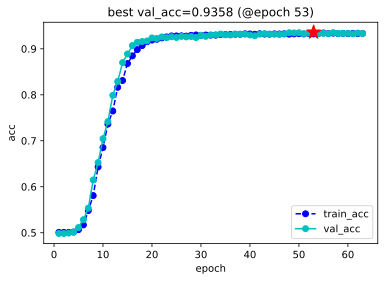

<<<<<< val_acc without improvement in 10 epoch,early stopping >>>>>> 



,epoch,train_loss,train_acc,lr,val_loss,val_acc
0,1,0.679980,0.500714,0.0001,0.677381,0.498333
1,2,0.672440,0.500714,0.0001,0.669870,0.498333
2,3,0.665197,0.500714,0.0001,0.662375,0.499167
3,4,0.657629,0.501429,0.0001,0.654409,0.501250
4,5,0.649424,0.506607,0.0001,0.645605,0.511250
...,...,...,...,...,...,...
58,59,0.168576,0.933571,0.0001,0.168746,0.933750
59,60,0.168791,0.933036,0.0001,0.167999,0.933750
60,61,0.167746,0.933571,0.0001,0.168132,0.932500
61,62,0.167640,0.933036,0.0001,0.167926,0.934167


In [31]:
from torchkeras.kerascallbacks import TensorBoardCallback

tb = TensorBoardCallback(
    save_dir='./data/tensorboard',
    model_name='model',
    log_weight=False,
    log_weight_freq=5,
)

model.fit( train_data=dl_train,
            val_data=dl_val,
            epochs=100,
            ckpt_path='checkpoint',
            patience=10,
            monitor='val_acc',
            mode='max',
            callbacks=[tb],
            plot=True,
            cpu=True)


### 4, TensorBoard可视化监控

In [ ]:
#!tensorboard --logdir="'./data/tensorboard'" --bind_all --port=6006

In [32]:
from tensorboard import notebook
notebook.list() 

No known TensorBoard instances running.


In [ ]:
notebook.start("--logdir './data/tensorboard' --port=6006")

#### metrics

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h412vlgpqdj20n40cmaaf.jpg)

#### graphs

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h4130c9g6lj20d90dd0st.jpg)

#### histograms 

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h4132au1scj20e709xjri.jpg) 



**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)